In [1]:
include("dsnb_funcs.jl")
using Optim;

In [98]:
# Loading the precomputed 2ν DSNB fluxes

function create_flux_dict_2ν_NO()
    dict_dsnb = Dict{Tuple{String, String, Bool, Float64},Vector{Float64}}()
    for i in 1:189
        filepath = "Data/dsnb_2nu_raw_data/outputs_NO/array_output_45705961_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        channel = parsed_data.args[2].args[1]
        prog = parsed_data.args[2].args[2]
        logα = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dict_dsnb[(channel, prog, true, logα)] = dsnb_nubar
        dict_dsnb[(channel, prog, false, logα)] = dsnb_nu
    end
    return dict_dsnb
end
function create_flux_dict_2ν_IO()
    dict = Dict{Tuple{String, String, Bool, Float64},Vector{Float64}}()
    for i in 1:189
        filepath = "Data/dsnb_2nu_raw_data/outputs_IO/array_output_45706156_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        channel = parsed_data.args[2].args[1]
        prog = parsed_data.args[2].args[2]
        logα = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dict[(channel, prog, true, logα)] = dsnb_nubar
        dict[(channel, prog, false, logα)] = dsnb_nu
    end
    return dict
end

dsnb_fluxes_2ν_NO_dict = create_flux_dict_2ν_NO()
dsnb_fluxes_2ν_IO_dict = create_flux_dict_2ν_IO()

function dsnb_2ν_freefbh_precomp(logα, nubar, ordering, daughter, fbh)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    if 1 - fsmall - fbh < 0
        fbh = 0.41
    elseif fbh < 0.09
        fbh = 0.09
    end
    flarge = 1 - fsmall - fbh

    if ordering == "NO"
        return fsmall*dsnb_fluxes_2ν_NO_dict[(daughter, "small", nubar, logα)] .+ flarge*dsnb_fluxes_2ν_NO_dict[(daughter, "large", nubar, logα)] .+ fbh*dsnb_fluxes_2ν_NO_dict[(daughter, "bh", nubar, logα)]
    elseif ordering == "IO"
        return fsmall*dsnb_fluxes_2ν_IO_dict[(daughter, "small", nubar, logα)] .+ flarge*dsnb_fluxes_2ν_IO_dict[(daughter, "large", nubar, logα)] .+ fbh*dsnb_fluxes_2ν_IO_dict[(daughter, "bh", nubar, logα)]
    else
        return println("error: ordering must be 'NO' or 'IO'")
    end
end

function dsnb_2ν_freefbh(E, logα, nubar, ordering, daughter, fbh)
    es = range(0.5, 40, 100)
    dsnb_interp = Interpolations.interpolate((vec(es),), dsnb_2ν_freefbh_precomp(logα, nubar, ordering, daughter, fbh), Gridded(Linear()))
    dsnb = extrapolate(dsnb_interp, 0.0)
    return dsnb(E)
end;

In [100]:
# Loading the precomputed 3ν IO DSNB fluxes 

# Case C: jobid = 45628098
# Case B: jobid = 45623263
# Case D: jobid = 45633812
function create_flux_dict_C()
    dsnb_fluxes_IO_C = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_C/array_output_45628098_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        prog = parsed_data.args[2].args[1]
        logα1 = log10(parsed_data.args[2].args[2])
        logα2 = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dsnb_fluxes_IO_C[(prog, true, logα1, logα2)] = dsnb_nubar
        dsnb_fluxes_IO_C[(prog, false, logα1, logα2)] = dsnb_nu
    end
    return dsnb_fluxes_IO_C
end;
function create_flux_dict_B()
    dsnb_fluxes_IO_B = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_B/array_output_45623263_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_B[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_B[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_B[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_B[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    for i in 1:960
        filepath = "Data/dsnb_IO_raw_data/outputs_B/newoutputs/array_output_45699351_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_B[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_B[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_B[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_B[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end

    return dsnb_fluxes_IO_B
end;
function create_flux_dict_D()
    dsnb_fluxes_IO_D = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_D/array_output_45633812_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_D[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_D[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_D[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_D[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_D
end;
# Invisible decays
function create_flux_dict_I()
    dsnb_fluxes_IO_I = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_I/array_output_45660110_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_I[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_I[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_I[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_I[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_I
end;

dsnb_fluxes_IO_C_dict = create_flux_dict_C()
dsnb_fluxes_IO_B_dict = create_flux_dict_B()
dsnb_fluxes_IO_D_dict = create_flux_dict_D()
dsnb_fluxes_IO_I_dict = create_flux_dict_I();

In [101]:
function dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    if 1 - fsmall - fbh < 0
        fbh = 0.41
    elseif fbh < 0.09
        fbh = 0.09
    end
    flarge = 1 - fsmall - fbh

    if casechoice == "B"
        return fsmall*dsnb_fluxes_IO_B_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_B_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_B_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "C"
        return fsmall*dsnb_fluxes_IO_C_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_C_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_C_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "D"
        return fsmall*dsnb_fluxes_IO_D_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_D_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_D_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "I"
        return fsmall*dsnb_fluxes_IO_I_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_I_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_I_dict[("bh", nubar, logα1, logα2)]
    else
        return zeros(100)
    end
end

function dsnb_3ν_IO_freefbh(E, logα1, logα2, nubar, casechoice, fbh)
    es = range(0.5, 40, 100)
    dsnb_interp = Interpolations.interpolate((vec(es),), dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh), Gridded(Linear()))
    dsnb = extrapolate(dsnb_interp, 0.0)
    return dsnb(E)
end;

In [103]:
@time dsnb_3ν_IO_freefbh_precomp(-25.0, -25.0, true, "D", 0.21)

  0.000048 seconds (13 allocations: 3.797 KiB)


100-element Vector{Float64}:
 0.18214109717475252
 0.17305267870728264
 0.16352530327322745
 0.15363494225894805
 0.14367315928984886
 0.13404165773543975
 0.12518890143378752
 0.11754481544413406
 0.11146651871879966
 0.10709272202850333
 0.10456126887979414
 0.10373725512816198
 0.10434361211973824
 ⋮
 0.002289086621132446
 0.002141708931103852
 0.0020042722764528603
 0.0018759673377902056
 0.0017563848102371243
 0.0016448045937500287
 0.0015406721877847943
 0.0014434776813921546
 0.0013527351436622092
 0.0012679025488389483
 0.001188724172031632
 0.0011147572426980156

In [104]:
es_dsnb = range(0.5, 40, 100)

dsnb_f21 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.21, SNRnorm)
dsnb_f41 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.41, SNRnorm)
dsnb_f09 = DSNB_freefbh.(es_dsnb, 0, true, "IO", 0.09, SNRnorm);

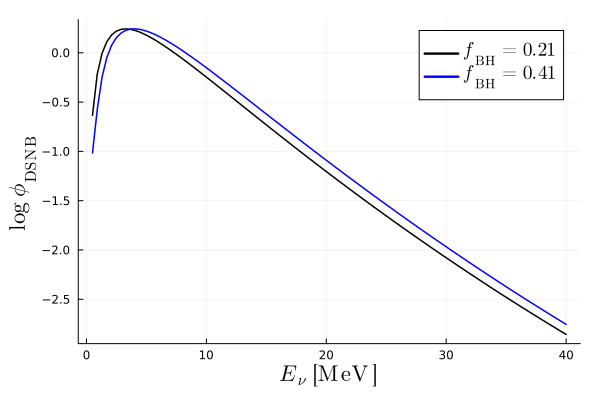

In [105]:
plot(
    es_dsnb,
    [log10.(dsnb_f21) log10.(dsnb_3ν_IO_freefbh_precomp(-26.4, -24.0, true, "B", 0.21))],
    lw=1.5,
    c=[:black :blue :red],
    label=[L"f_\mathrm{BH} = 0.21" L"f_\mathrm{BH} = 0.41" L"f_\mathrm{BH} = 0.09"],
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    ylabel=L"\log~\phi_\mathrm{DSNB}",
    legendfontsize=13,
    xlabelfontsize=15,
    ylabelfontsize=15,
    margins=3Plots.mm
)

In [106]:
nueCCxc_data = readdlm("Data/nueCC_xc.txt")

nueCC_es = 10 .^ nueCCxc_data[:,1] # GeV
σ_νeCC_vec = nueCCxc_data[:,2] .* nueCC_es .* 1e-38

σ_νeCC_interp = Interpolations.interpolate((vec(nueCC_es)*1000,), σ_νeCC_vec, Gridded(Linear()))
σ_νeCC = extrapolate(σ_νeCC_interp, 0.0)

KνeCC(u, v) = (1/(0.2*v*sqrt(2*π)))*exp(-((u-v)/(0.2*v*sqrt(2)))^2)
binint_KνeCC(Ertrue, Erreco_min, Erreco_max) = quadgk(Ereco -> KνeCC(Ertrue, Ereco), Erreco_min, Erreco_max)[1]

binint_KνeCC (generic function with 1 method)

In [188]:
# Implementing the detector stuff now

Δ = mass_neutron - mass_proton

# Response function
# K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)


function Nt_ϵ(exp)
    if exp == "HK"
        return (2.5e34, 0.67)
    elseif exp == "JUNO"
        return (1.2e33, 0.5)
    elseif exp == "DUNE"
        return (6.02e32, 0.86)
    else
        return println("Invalid experiment choice")
    end
end

function σ(Eν, exp)
    if exp == "HK" || exp == "JUNO"
        return σIBD(Eν)
    elseif exp == "DUNE"
        return σ_νeCC(Eν)
    else
        return println("Invalid experiment choice")
    end
end

function binint_K(Et, Er_min, Er_max, exp)
    if exp == "HK" || exp == "JUNO"
        return binint_KIBD(Et, Er_min, Er_max)
    elseif exp == "DUNE"
        return binint_KνeCC(Et, Er_min, Er_max)
    else
        return println("Invalid experiment choice")
    end
end

function diff_event_rate_2ν(E, α, ordering, daughter, fbh, normchoice, exp)
    Eν = E + Δ
    if exp == "DUNE"
        nubar = false
    else
        nubar = true
    end
    if α == 0.0
        return σ(Eν, exp) * DSNB_freefbh(Eν, 0.0, nubar, ordering, fbh, normchoice)
    else
        return σ(Eν, exp) * dsnb_2ν_freefbh(Eν, log10(α), nubar, ordering, string(daughter), fbh)
    end
end

function event_rate_2ν(Emin, Emax, α, ordering, daughter, fbh, normchoice, yrs, exp)
    if exp == "DUNE"
        Etmin, Etmax = maximum([0, (Emin - 4*0.2*Emin)]), Emax + 4*0.2*Emax
    else
        Etmin, Etmax = maximum([0, (Emin - 4*0.1*sqrt(Emin))]), Emax + 4*0.1*sqrt(Emax)
    end
    Nt, ϵ = Nt_ϵ(exp)
    τ = yrs*525600*60
    return τ * Nt * ϵ * quadgk(Et -> 
        diff_event_rate_2ν(Et, α, ordering, daughter, fbh, normchoice, exp)*binint_K(Et, Emin, Emax, exp), Etmin, Etmax, rtol=1e-3)[1]
end

function diff_event_rate_3ν(E, α1, α2, casechoice, fbh, normchoice, exp)
    Eν = E + Δ
    if exp == "DUNE"
        nubar = false
    else
        nubar = true
    end
    if α1 == 0.0 && α2 == 0.0
        return σ(Eν, exp) * DSNB_freefbh(Eν, 0.0, nubar, "IO", fbh, normchoice)
    else
        return σ(Eν, exp) * dsnb_3ν_IO_freefbh(Eν, log10(α1), log10(α2), nubar, casechoice, fbh)
    end
end

function event_rate_3ν(Emin, Emax, α1, α2, casechoice, fbh, normchoice, yrs, exp)
    if exp == "DUNE"
        Etmin, Etmax = maximum([0, (Emin - 4*0.2*Emin)]), Emax + 4*0.2*Emax
    else
        Etmin, Etmax = maximum([0, (Emin - 4*0.1*sqrt(Emin))]), Emax + 4*0.1*sqrt(Emax)
    end
    Nt, ϵ = Nt_ϵ(exp)
    τ = yrs*525600*60
    return τ * Nt * ϵ * quadgk(Et -> 
        diff_event_rate_3ν(Et, α1, α2, casechoice, fbh, normchoice, exp)*binint_K(Et, Emin, Emax, exp), Etmin, Etmax, rtol=1e-3)[1]
end;

In [194]:
@time event_rate_3ν(19, 21, 1e-27, 1e-25, "C", 0.21, SNRnorm, 20, "DUNE")

  0.000515 seconds (1.54 k allocations: 197.766 KiB)


1.325439618737593

In [192]:
@time event_rate_2ν(19, 21, 1e-25, "IO", 3, 0.21, SNRnorm, 20, "DUNE")

  0.001058 seconds (1.59 k allocations: 200.930 KiB)


1.3348025329333313

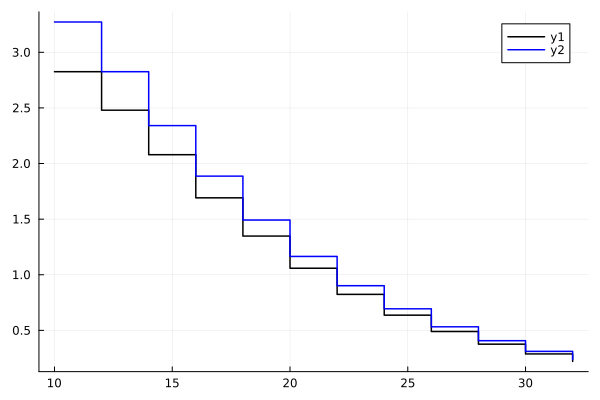

In [187]:
emins_HK, emaxes_HK = 12:2:30, 14:2:32
emins_JUNO, emaxes_JUNO = 10:2:32, 12:2:34
emins_DUNE, emaxes_DUNE = 19:2:29, 21:2:31

dsnb_nodecay_JUNO = event_rate_2ν.(emins_JUNO, emaxes_JUNO, 0.0, "NO", 1, 0.21, SNRnorm, 20, "JUNO")
dsnb_nodecay_DUNE = event_rate_2ν.(emins_DUNE, emaxes_DUNE, 0.0, "NO", 1, 0.21, SNRnorm, 20, "DUNE")
dsnb_vdecay_JUNO = event_rate_2ν.(emins_JUNO, emaxes_JUNO, 1e-23, "NO", 1, 0.21, SNRnorm, 20, "JUNO")
dsnb_vdecay_DUNE = event_rate_2ν.(emins_DUNE, emaxes_DUNE, 1e-23, "NO", 1, 0.21, SNRnorm, 20, "DUNE")

plot(
    emins_JUNO,
    [dsnb_nodecay_JUNO dsnb_vdecay_JUNO],
    seriestype=:step,
    lw=1.5,
    c=[:black :blue],
)

In [ ]:
#=
function diff_event_rate_IBD_2ν(Ee, α, ordering, daughter, fbh, normchoice)
    Eν = Ee + Δ
    if α == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_freefbh(Eν, 0.0, true, ordering, fbh, normchoice)
    else
        return ϵIBD * NtIBD * σIBD(Eν) * dsnb_2ν_freefbh(Eν, log10(α), true, ordering, string(daughter), fbh)
    end
end

function event_rate_IBD_2ν(Ee_min, Ee_max, α, ordering, daughter, fbh, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD_2ν(Eetrue, α, ordering, daughter, fbh, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;


# Just focusing on ν3 decay rn, IO: casechoice="I" means invisible decay
function diff_event_rate_IBD_IO(Ee, α1, α2, casechoice, fbh, normchoice)
    Eν = Ee + Δ
    if α1 == 0.0 && α2 == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_freefbh(Eν, 0.0, true, "IO", fbh, normchoice)
    else
        return ϵIBD * NtIBD * σIBD(Eν) * dsnb_3ν_IO_freefbh(Eν, log10(α1), log10(α2), true, casechoice, fbh)
    end
end

function event_rate_IBD_IO(Ee_min, Ee_max, α1, α2, casechoice, fbh, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD_IO(Eetrue, α1, α2, casechoice, fbh, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;
=#

In [289]:
# Reading in the backgrounds
HK_ebin_lowerbnds, HK_atmCC_vec = [readdlm("Data/dsnb_backgrounds/HK_atmCC.csv", ',')[:, i] for i in 1:2]
HK_atmNC_vec = readdlm("Data/dsnb_backgrounds/HK_atmNC.csv", ',')[:, 2]
HK_invismuon_vec = readdlm("Data/dsnb_backgrounds/HK_invismuon.csv", ',')[:, 2]
HK_li9spallation_vec = readdlm("Data/dsnb_backgrounds/HK_li9spallation.csv", ',')[:, 2]

JUNO_ebin_lowerbnds, JUNO_atmCC_vec = [readdlm("Data/dsnb_backgrounds/JUNO_atmCC.csv", ',')[:, i] for i in 1:2]
JUNO_atmNC_vec = readdlm("Data/dsnb_backgrounds/JUNO_atmNC.csv", ',')[:, 2]

DUNE_ebin_lowerbnds, DUNE_atmCC_vec = [readdlm("Data/dsnb_backgrounds/DUNE_atmCC.csv", ',')[:, i] for i in 1:2]

emins_HK, emaxes_HK = 12:2:30, 14:2:32
emins_JUNO, emaxes_JUNO = 10:2:32, 12:2:34
emins_DUNE, emaxes_DUNE = 19:2:29, 21:2:31;

function emins_exp(exp)
    if exp == "HK"
        return 12:2:30
    elseif exp == "JUNO"
        return 10:2:32
    elseif exp == "DUNE"
        return 19:2:29
    else
        return println("Invalid experiment choice")
    end
end

emins_exp (generic function with 1 method)

In [320]:
background_HK(i, ηCC, ηNC, ηiμ, ηLi) = ηCC*HK_atmCC_vec[i] + ηNC*HK_atmNC_vec[i] + ηiμ*HK_invismuon_vec[i] + ηLi*HK_li9spallation_vec[i]
background_JUNO(i, ηCC, ηNC) = ηCC*JUNO_atmCC_vec[i] + ηNC*JUNO_atmNC_vec[i]
background_DUNE(i, ηCC) = ηCC*DUNE_atmCC_vec[i]

# Unminimized χ², fixed fbh with NC
function χ2_um(ξ, ηCC, ηNC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
    if exp == "HK"
        χ0 = [((1+ξ)*altsig[i] + background_HK(i, ηCC, ηNC, ηiμ, ηLi) - nullsig[i] + 
            (nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))
            *log((nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 1+ηNC, 1+ηiμ, 1+ηLi)))) for i in 1:length(emins_HK)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
    elseif exp == "JUNO"
        χ0 = [((1+ξ)*altsig[i] + background_JUNO(i, ηCC, ηNC) - nullsig[i] + 
            (nullsig[i] + background_JUNO(i, 1.0, 1.0))
            *log((nullsig[i] + background_JUNO(i, 1.0, 1.0))/((1+ξ)*altsig[i] + background_JUNO(i, 1+ηCC, 1+ηNC)))) for i in 1:length(emins_JUNO)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2
    elseif exp == "DUNE"
        χ0 = [((1+ξ)*altsig[i] + background_DUNE(i, ηCC) - nullsig[i] + 
            (nullsig[i] + background_DUNE(i, 1.0))
            *log((nullsig[i] + background_DUNE(i, 1.0))/((1+ξ)*altsig[i] + background_DUNE(i, 1+ηCC)))) for i in 1:length(emins_DUNE)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2
    else
        return println("Invalid experiment choice")
    end
end

# Unminimized χ², fixed fbh without NC
function χ2_um(ξ, ηCC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
    if exp == "HK"
        χ0 = [((1+ξ)*altsig[i] + background_HK(i, ηCC, 0.0, ηiμ, ηLi) - nullsig[i] + 
            (nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))
            *log((nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 0.0, 1+ηiμ, 1+ηLi)))) for i in 1:length(emins_HK)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
    elseif exp == "JUNO"
        χ0 = [((1+ξ)*altsig[i] + background_JUNO(i, ηCC, 0.0) - nullsig[i] + 
            (nullsig[i] + background_JUNO(i, 1.0, 0.0))
            *log((nullsig[i] + background_JUNO(i, 1.0, 0.0))/((1+ξ)*altsig[i] + background_JUNO(i, 1+ηCC, 0.0)))) for i in 1:length(emins_JUNO)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2
    elseif exp == "DUNE"
        χ0 = [((1+ξ)*altsig[i] + background_DUNE(i, ηCC) - nullsig[i] + 
            (nullsig[i] + background_DUNE(i, 1.0))
            *log((nullsig[i] + background_DUNE(i, 1.0))/((1+ξ)*altsig[i] + background_DUNE(i, 1+ηCC)))) for i in 1:length(emins_DUNE)]
        return sum(χ0) + (ξ/σRSN)^2 + (ηCC/σn)^2
    else
        return println("Invalid experiment choice")
    end
end

# Unminimized χ², free fbh with NC, 2ν
function χ2_um(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsig, σRSN, σn, α, ordering::String, daughter, exp)
    emins, emaxes = emins_exp(exp), emins_exp(exp) .+ 2
    altsig = event_rate_2ν.(emins, emaxes, α, ordering, daughter, fbh, SNRnorm, 20, exp)
    return χ2_um(ξ, ηCC, ηNC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
end

# Unminimized χ², free fbh without NC, 2ν
function χ2_um(fbh, ξ, ηCC, ηiμ, ηLi, nullsig, σRSN, σn, α, ordering::String, daughter, exp)
    emins, emaxes = emins_exp(exp), emins_exp(exp) .+ 2
    altsig = event_rate_2ν.(emins, emaxes, α, ordering, daughter, fbh, SNRnorm, 20, exp)
    return χ2_um(ξ, ηCC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
end

# Unminimized χ², free fbh with NC, 3ν IO
function χ2_um(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsig, σRSN, σn, α1, α2, casechoice::String, exp)
    emins, emaxes = emins_exp(exp), emins_exp(exp) .+ 2
    altsig = event_rate_3ν.(emins, emaxes, α1, α2, casechoice, fbh, SNRnorm, 20, exp)
    return χ2_um(ξ, ηCC, ηNC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
end

# Unminimized χ², free fbh without NC, 3ν IO
function χ2_um(fbh, ξ, ηCC, ηiμ, ηLi, nullsig, σRSN, σn, α1, α2, casechoice::String, exp)
    emins, emaxes = emins_exp(exp), emins_exp(exp) .+ 2
    altsig = event_rate_3ν.(emins, emaxes, α1, α2, casechoice, fbh, SNRnorm, 20, exp)
    return χ2_um(ξ, ηCC, ηiμ, ηLi, nullsig, altsig, σRSN, σn, exp)
end

# Combined unminimized χ², free fbh with NC, 2ν
function χ2_um_combined(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α, ordering::String, daughter)
    return (χ2_um(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, σRSN, σn, α, ordering, daughter, "HK")
    + χ2_um(fbh, ξ, ηCC, ηNC, 0.0, 0.0, nullsigJUNO, σRSN, σn, α, ordering, daughter, "JUNO")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigDUNE, σRSN, σn, α, ordering, daughter, "DUNE"))
end

# Combined unminimized χ², free fbh without NC, 2ν
function χ2_um_combined(fbh, ξ, ηCC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α, ordering::String, daughter)
    return (χ2_um(fbh, ξ, ηCC, ηiμ, ηLi, nullsigHK, σRSN, σn, α, ordering, daughter, "HK")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigJUNO, σRSN, σn, α, ordering, daughter, "JUNO")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigDUNE, σRSN, σn, α, ordering, daughter, "DUNE"))
end

# Combined unminimized χ², free fbh with NC, 3ν IO
function χ2_um_combined(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α1, α2, casechoice::String)
    return (χ2_um(fbh, ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, σRSN, σn, α1, α2, casechoice, "HK")
    + χ2_um(fbh, ξ, ηCC, ηNC, 0.0, 0.0, nullsigJUNO, σRSN, σn, α1, α2, casechoice, "JUNO")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigDUNE, σRSN, σn, α1, α2, casechoice, "DUNE"))
end

# Combined unminimized χ², free fbh without NC, 3ν IO
function χ2_um_combined(fbh, ξ, ηCC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α1, α2, casechoice::String)
    return (χ2_um(fbh, ξ, ηCC, ηiμ, ηLi, nullsigHK, σRSN, σn, α1, α2, casechoice, "HK")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigJUNO, σRSN, σn, α1, α2, casechoice, "JUNO")
    + χ2_um(fbh, ξ, ηCC, 0.0, 0.0, nullsigDUNE, σRSN, σn, α1, α2, casechoice, "DUNE"))
end

# Combined unmiminized χ², fixed fbh with NC
function χ2_um_combined(ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE, σRSN, σn)

    return (χ2_um(ξ, ηCC, ηNC, ηiμ, ηLi, nullsigHK, altsigHK, σRSN, σn, "HK")
    + χ2_um(ξ, ηCC, ηNC, 0.0, 0.0, nullsigJUNO, altsigJUNO, σRSN, σn, "JUNO")
    + χ2_um(ξ, ηCC, 0.0, 0.0, nullsigDUNE, altsigDUNE, σRSN, σn, "DUNE"))
end

# Combined unmiminized χ², fixed fbh without NC
function χ2_um_combined(ξ, ηCC, ηiμ, ηLi, nullsigHK, nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE, σRSN, σn)

    return (χ2_um(ξ, ηCC, ηiμ, ηLi, nullsigHK, altsigHK, σRSN, σn, "HK")
    + χ2_um(ξ, ηCC, 0.0, 0.0, nullsigJUNO, altsigJUNO, σRSN, σn, "JUNO")
    + χ2_um(ξ, ηCC, 0.0, 0.0, nullsigDUNE, altsigDUNE, σRSN, σn, "DUNE"))
end




function χ2_2ν(α, ordering, daughter, σRSN, σn, freefbh, withNC, exp)

    if exp == "HK"
        emins, emaxes = emins_exp("HK"), emins_exp("HK") .+ 2
        nullsig = event_rate_2ν.(emins, emaxes, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "HK")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], x[6], nullsig, σRSN, σn, α, ordering, daughter, "HK"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], nullsig, σRSN, σn, α, ordering, daughter, "HK"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsig = event_rate_2ν.(emins, emaxes, α, ordering, daughter, 0.21, SNRnorm, 20, "HK")
            if withNC
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], nullsig, altsig, σRSN, σn, "HK"), 
                    zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], nullsig, altsig, σRSN, σn, "HK"), 
                    zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    elseif exp == "JUNO"
        emins, emaxes = emins_exp("JUNO"), emins_exp("JUNO") .+ 2
        nullsig = event_rate_2ν.(emins, emaxes, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "JUNO")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], 0.0, 0.0, nullsig, σRSN, σn, α, ordering, daughter, "JUNO"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, σRSN, σn, α, ordering, daughter, "JUNO"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsig = event_rate_2ν.(emins, emaxes, α, ordering, daughter, 0.21, SNRnorm, 20, "JUNO")
            if withNC
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, altsig, σRSN, σn, "JUNO"), 
                    zeros(3), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], 0.0, 0.0, nullsig, altsig, σRSN, σn, "JUNO"), 
                    zeros(2), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    elseif exp == "DUNE"
        emins, emaxes = emins_exp("DUNE"), emins_exp("DUNE") .+ 2
        nullsig = event_rate_2ν.(emins, emaxes, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "DUNE")
        if freefbh
            x0 = [0.21, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, σRSN, σn, α, ordering, daughter, "DUNE"), 
                x0, NelderMead(), Optim.Options(g_tol=1e-3))
        else
            altsig = event_rate_2ν.(emins, emaxes, α, ordering, daughter, 0.21, SNRnorm, 20, "DUNE")
            optimized = Optim.optimize(x -> χ2_um(x[1], x[2], 0.0, 0.0, nullsig, altsig, σRSN, σn, "DUNE"), 
                zeros(2), NelderMead(), Optim.Options(g_tol=1e-3))
        end
    elseif exp == "combined"
        nullsigHK = event_rate_2ν.(emins_exp("HK"), emins_exp("HK") .+ 2, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "HK")
        nullsigJUNO = event_rate_2ν.(emins_exp("JUNO"), emins_exp("JUNO") .+ 2, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "JUNO")
        nullsigDUNE = event_rate_2ν.(emins_exp("DUNE"), emins_exp("DUNE") .+ 2, 0.0, ordering, daughter, 0.21, SNRnorm, 20, "DUNE")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5], x[6],
                    nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α, ordering, daughter), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5],
                    nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α, ordering, daughter), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsigHK = event_rate_2ν.(emins_exp("HK"), emins_exp("HK") .+ 2, α, ordering, daughter, 0.21, SNRnorm, 20, "HK")
            altsigJUNO = event_rate_2ν.(emins_exp("JUNO"), emins_exp("JUNO") .+ 2, α, ordering, daughter, 0.21, SNRnorm, 20, "JUNO")
            altsigDUNE = event_rate_2ν.(emins_exp("DUNE"), emins_exp("DUNE") .+ 2, α, ordering, daughter, 0.21, SNRnorm, 20, "DUNE")
            if withNC
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5], nullsigHK, 
                nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE,
                σRSN, σn, α, ordering::String, daughter),
                zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], nullsigHK, 
                nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE,
                σRSN, σn, α, ordering::String, daughter),
                zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    else
        return println("Error: invalid experiment choice")
    end
    min, minimizer = optimized.minimum, optimized.minimizer
    if freefbh
        if minimizer[1] < 0.09
            minimizer[1] = 0.09
        elseif minimizer[1] > 0.41
            minimizer[1] = 0.41
        end
    end
    return min, minimizer
end

function χ2_3ν(α1, α2, casechoice, σRSN, σn, freefbh, withNC, exp)

    if exp == "HK"
        emins, emaxes = emins_exp("HK"), emins_exp("HK") .+ 2
        nullsig = event_rate_3ν.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "HK")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], x[6], nullsig, σRSN, σn, α1, α2, casechoice, "HK"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], nullsig, σRSN, σn, α1, α2, casechoice, "HK"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsig = event_rate_3ν.(emins, emaxes, α1, α2, casechoice, 0.21, SNRnorm, 20, "HK")
            if withNC
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], x[5], nullsig, altsig, σRSN, σn, "HK"), 
                    zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], nullsig, altsig, σRSN, σn, "HK"), 
                    zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    elseif exp == "JUNO"
        emins, emaxes = emins_exp("JUNO"), emins_exp("JUNO") .+ 2
        nullsig = event_rate_3ν.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "JUNO")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], x[4], 0.0, 0.0, nullsig, σRSN, σn, α1, α2, casechoice, "JUNO"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, σRSN, σn, α1, α2, casechoice, "JUNO"), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsig = event_rate_3ν.(emins, emaxes, α1, α2, casechoice, 0.21, SNRnorm, 20, "JUNO")
            if withNC
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, altsig, σRSN, σn, "JUNO"), 
                    zeros(3), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um(x[1], x[2], 0.0, 0.0, nullsig, altsig, σRSN, σn, "JUNO"), 
                    zeros(2), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    elseif exp == "DUNE"
        emins, emaxes = emins_exp("DUNE"), emins_exp("DUNE") .+ 2
        nullsig = event_rate_3ν.(emins, emaxes, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "DUNE")
        if freefbh
            x0 = [0.21, 0.0, 0.0]
            optimized = Optim.optimize(x -> χ2_um(x[1], x[2], x[3], 0.0, 0.0, nullsig, σRSN, σn, α1, α2, casechoice, "DUNE"), 
                x0, NelderMead(), Optim.Options(g_tol=1e-3))
        else
            altsig = event_rate_3ν.(emins, emaxes, α1, α2, casechoice, 0.21, SNRnorm, 20, "DUNE")
            optimized = Optim.optimize(x -> χ2_um(x[1], x[2], 0.0, 0.0, nullsig, altsig, σRSN, σn, "DUNE"), 
                zeros(2), NelderMead(), Optim.Options(g_tol=1e-3))
        end
    elseif exp == "combined"
        nullsigHK = event_rate_3ν.(emins_exp("HK"), emins_exp("HK") .+ 2, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "HK")
        nullsigJUNO = event_rate_3ν.(emins_exp("JUNO"), emins_exp("JUNO") .+ 2, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "JUNO")
        nullsigDUNE = event_rate_3ν.(emins_exp("DUNE"), emins_exp("DUNE") .+ 2, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "DUNE")
        if freefbh
            if withNC
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5], x[6],
                    nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α1, α2, casechoice), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            else
                x0 = [0.21, 0.0, 0.0, 0.0, 0.0]
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5],
                    nullsigHK, nullsigJUNO, nullsigDUNE, σRSN, σn, α1, α2, casechoice), 
                    x0, NelderMead(), Optim.Options(g_tol=1e-3))
            end
        else
            altsigHK = event_rate_3ν.(emins_exp("HK"), emins_exp("HK") .+ 2, α1, α2, casechoice, 0.21, SNRnorm, 20, "HK")
            altsigJUNO = event_rate_3ν.(emins_exp("JUNO"), emins_exp("JUNO") .+ 2, α1, α2, casechoice, 0.21, SNRnorm, 20, "JUNO")
            altsigDUNE = event_rate_3ν.(emins_exp("DUNE"), emins_exp("DUNE") .+ 2, α1, α2, casechoice, 0.21, SNRnorm, 20, "DUNE")
            if withNC
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], x[5], nullsigHK, 
                nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE,
                σRSN, σn),
                zeros(5), NelderMead(), Optim.Options(g_tol=1e-3))
            else
                optimized = Optim.optimize(x -> χ2_um_combined(x[1], x[2], x[3], x[4], nullsigHK, 
                nullsigJUNO, nullsigDUNE, altsigHK, altsigJUNO, altsigDUNE,
                σRSN, σn),
                zeros(4), NelderMead(), Optim.Options(g_tol=1e-3))
            end
        end
    else
        return println("Error: invalid experiment choice")
    end
    min, minimizer = optimized.minimum, optimized.minimizer
    if freefbh
        if minimizer[1] < 0.09
            minimizer[1] = 0.09
        elseif minimizer[1] > 0.41
            minimizer[1] = 0.41
        end
    end
    return min, minimizer
end

χ2_3ν (generic function with 1 method)

In [353]:
eminstest, emaxestest = emins_exp("JUNO"), emins_exp("JUNO") .+ 2
nullsigtest = event_rate_3ν.(eminstest, emaxestest, 0.0, 0.0, "I", 0.21, SNRnorm, 20, "JUNO")
χ2_um(0.21, 0.0, 0.0, 0.0, 0.0, nullsigtest, 0.2, 0.2, 1e-24, 1e-24, "I", "JUNO")

23.128600998722234

In [365]:
@time χ2_2ν(1e-23, "IO", 3, 0.2, 0.2, false, false, "combined")

  0.198609 seconds (2.67 M allocations: 49.878 MiB, 8.03% gc time)


(3.125172364143465, [0.09725049648674278, 0.0045305187089530055, 0.06908590537298115, 0.08978546190129227])

In [367]:
αs = 10 .^ range(-27, -23, 21)
chi2_idecay = zeros(21, 21)

for (i, α1) in enumerate(αs)
    for (j, α2) in enumerate(αs)
        χ2mat = χ2_3ν(α1, α2, "B", 0.01, 0.01, false, false, "combined")
        chi2_idecay[i, j] = χ2mat[1]
    end
end

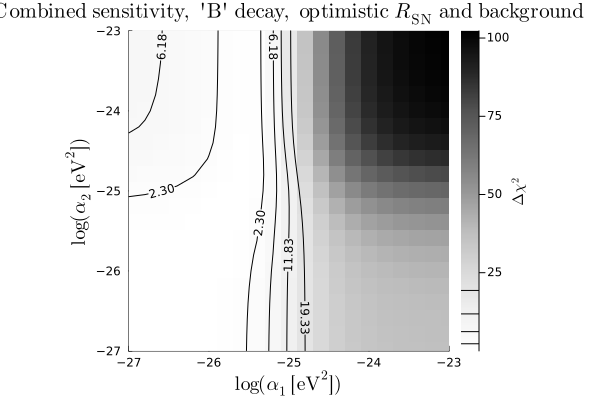

In [370]:
heatmap(
    log10.(αs),
    log10.(αs),
    transpose(chi2_idecay), 
    aspect_ratio=1, 
    c=:Greys,
    xlims=(-27,-23),
    ylims=(-27,-23),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    colorbartitle=L"\Delta \chi^2",
    title=L"\mathrm{Combined~sensitivity,~'B'~decay,~optimistic~}R_\mathrm{SN}~\mathrm{and~background}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13
)
contour!(
    log10.(αs),
    log10.(αs),
    transpose(chi2_idecay),
    levels=[2.3, 6.18, 11.83, 19.33],
    lw=1,
    clabels=true,
    c=:black
)